# Описание проекта и план выполнения

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

Датасет - информация из клиентской базы телекоммуникационной компании.

**Аналитическая задача** — построить регрессионную/классифицирующую модель.

## Описание данных:
Каждый клиент описывается следующим набором признаков:
- `Возраст`, `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Звонки в другие страны`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`, `Дата подключения тарифа`.
</div>

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

## План выполнения:
- Загружаем данные и библиотеки
- Проводим первичный краткий EDA
- Выбираем ML-модель и ставим задачу ререссии/классификации
- Создаем класс с функциями загрузки данных, EDA первичных данных, фильтрации и очистки данных, EDA очищенных данных, предикта, GSCV
- Оцениваем r2_score
</div>

# Загрузка библиотек и датасета

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transliterate

from catboost import CatBoostRegressor, Pool

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [375]:
df.head(5)

,vozrast,srednemesjachnyj_rashod,srednjaja_prodolzhitel_nost__razgovorov,zvonkov_dnem_za_mesjats,zvonkov_vecherom_za_mesjats,zvonkov_noch_ju_za_mesjats,zvonki_v_drugie_goroda,zvonki_v_drugie_strany,dolja_zvonkov_na_statsionarnye_telefony,kolichestvo_sms_za_mesjats,data_podkljuchenija_tarifa
0,24.0,NaN,2.4,12.0,65.0,5.0,0.0,0.0,5.0,56.0,20180617121435
1,51.0,287.51,1.7,111.0,109.0,1.0,44.0,0.0,6.0,1.0,20211021153954
2,41.0,113.70,2.1,41.0,27.0,0.0,0.0,0.0,1.0,36.0,20150326112615
3,35.0,410.23,5.6,47.0,49.0,0.0,0.0,0.0,11.0,23.0,20160104155320
4,26.0,537.60,4.8,58.0,77.0,4.0,0.0,0.0,16.0,29.0,20170503133353


In [18]:
df = pd.read_csv('dataset_telecom.csv')

# Первичный краткий EDA

In [20]:
df.head(3)

,Возраст,Среднемесячный расход,Средняя продолжительность разговоров,Звонков днем за месяц,Звонков вечером за месяц,Звонков ночью за месяц,Звонки в другие города,Звонки в другие страны,Доля звонков на стационарные телефоны,Количество SMS за месяц,Дата подключения тарифа
0,24,NaN,2.4,12.0,65.0,5,0,0,5,56,2018-06-17 12:14:35
1,51,287.51,1.7,111.0,109.0,1,44,0,6,1,2021-10-21 15:39:54
2,41,113.70,2.1,41.0,27.0,0,0,0,1,36,2015-03-26 11:26:15


In [22]:
df.shape

(4492, 11)

In [31]:
# В данных есть пропуски
df.isna().sum()

Возраст                                   0
Среднемесячный расход                    24
Средняя продолжительность разговоров     17
Звонков днем за месяц                    20
Звонков вечером за месяц                  3
Звонков ночью за месяц                    0
Звонки в другие города                    0
Звонки в другие страны                    0
Доля звонков на стационарные телефоны     0
Количество SMS за месяц                   0
Дата подключения тарифа                   0
dtype: int64

In [30]:
# В данных многие колонки имеют еще и неверный тип данных
df.dtypes

Возраст                                    int64
Среднемесячный расход                    float64
Средняя продолжительность разговоров     float64
Звонков днем за месяц                    float64
Звонков вечером за месяц                 float64
Звонков ночью за месяц                    object
Звонки в другие города                    object
Звонки в другие страны                     int64
Доля звонков на стационарные телефоны     object
Количество SMS за месяц                   object
Дата подключения тарифа                   object
dtype: object

**Что необходимо сделать с данными:**
- переименовать столбы в латинницу
- преобразовать типы данных
- обработать пропуски
- убрать дубликаты (если есть)
- найти выбросы
- убрать выбросы
- провести feature engineering

# Выбор ML-модели

Для выбранного датасета мы выберем модель регрессии и будем предсказывать колонку "Среднемесячный расход" на основе остальных колонок.

В качестве регрессионной модели возьмем Catboost.

# Создание класса для получения предикта

In [367]:
class ml_dataset:
    def __init__(self, name:str, path:str):
        self.name = name
        self.df = pd.read_csv(path)
    
    # Функция загрузки данных и краткого EDA
    def describe_data(self):
        print(f'Размер датасета: {self.df.shape} - {self.df.shape[0]} строк и {self.df.shape[1]} колонок')
        print(f'\nКоличество пропусков в данных: {self.df.isna().sum().sum()}')
        print(f'\nТипы данных в колонках:\n{self.df.dtypes}')
        print(f'\nКоличество дубликатов: {self.df.duplicated().sum()}')
        print(f'\nКоличество уникальных значений в колонках:\n{self.df.nunique()}')
        print(f'\nРазмер датасета в памяти: {self.df.memory_usage().sum() / 1024 ** 2:.2f} MB')
    
    # Поподготавливаем данные
    def data_transform(self):

        # КОрректируем заголовки колонок
        def cyrillic_to_latin(text):
            return transliterate.translit(text, reversed=True).replace(" ", "_").replace("'", "_").lower()
        self.df.columns = [cyrillic_to_latin(col) for col in self.df.columns]
        for i in self.df.columns:
            if self.df[i].dtype == 'object':
                self.df[i] = self.df[i].astype(str).str.replace("[^0-9.]", "", regex=True)

        # Корректируем типы данных
        for i in self.df.columns:
            if i != 'data_podkljuchenija_tarifa':
                self.df[i] = self.df[i].astype('float')
        self.df['data_podkljuchenija_tarifa'] = self.df['data_podkljuchenija_tarifa'].apply(pd.to_datetime)

        # Заполняем пропуски
        self.df['zvonkov_vecherom_za_mesjats'].fillna(self.df['zvonkov_vecherom_za_mesjats'].mean(), inplace=True)
        self.df['zvonkov_dnem_za_mesjats'].fillna(self.df['zvonkov_dnem_za_mesjats'].mean(), inplace=True)
        self.df['srednjaja_prodolzhitel_nost__razgovorov'].fillna(self.df['srednjaja_prodolzhitel_nost__razgovorov'].mean(), inplace=True)
        self.df['srednemesjachnyj_rashod'].fillna(self.df['srednemesjachnyj_rashod'].mean(), inplace=True)

        # Удаляем дубликаты
        self.df.drop_duplicates(inplace=True)

        print('Данные подготовлены!')

    # Исправляем аномалии в данных
    def data_anomaly(self, fix=False):
        res = []
        
        for i in self.df.columns:
            if i != 'data_podkljuchenija_tarifa':
                q1 = self.df[i].quantile(0.25)
                q3 = self.df[i].quantile(0.75)
                qr = (q3 - q1) * 1.5
                outliers = self.df.query(f'{i} > {q3 + qr} or {i} < {q1 - qr}')
                
                if len(outliers) > 0 and fix == True:
                    print(f'В колонке "{i}" есть выбросы. Они меньше {q1 - qr} и больше {q3 + qr}')
                    res.append(False)

                    # Замена выбросов на среднее значение
                    mean_value = self.df[i].mean()
                    self.df.loc[outliers.index, i] = mean_value
                    print(f'Значения заменены на {mean_value}')                    
                else:
                    res.append(True)

        if all(res):
            print('В колонках датафрейма нет аномальных значений!')

    # Добавляем новые фичи
    def feature_engineering(self):
        def vozr(x):
            if 24 >= x >= 19:
                return 'студент'
            elif 33 >= x >= 25:
                return 'аспирант'
            elif 56 >= x >= 34:
                return 'бизнесмен'
            elif 70 >= x >= 57:
                return 'знаток'
        self.df['vozrast_category'] = self.df['vozrast'].apply(vozr)
        self.df['god_podkl'] = self.df['data_podkljuchenija_tarifa'].dt.year
        self.df['month_podkl'] = self.df['data_podkljuchenija_tarifa'].dt.month
        self.df['day_podkl'] = self.df['data_podkljuchenija_tarifa'].dt.day

        print('Новые фичи добавлены! Такие как: vozrast_category, god_podkl, month_podkl, day_podkl')

    # Визуализация данных
    def plots(self, type:str):
        for i in self.df.columns:
            if self.df[i].dtype != 'object':
                if type == 'hist':
                    self.df[i].hist()
                    plt.title(i)
                    plt.show()
                elif type == 'box':
                    sns.boxplot(self.df[i])
                    plt.title(i)
                    plt.show()
                elif type == 'kde':
                    sns.kdeplot(self.df[i])
                    plt.title(i)
                    plt.show()
                else:
                    print('Неверный тип графика. Доступные типы: hist, box')
                    break

    # EDA                    
    def eda(self):
        print('Выберите опцию для анализа:')
        print('1. Самый прибыльный год')
        print('2. Самый прибыльный месяц')
        print('3. Самый прибыльный день')
        print('4. ТОП-10 дней по числу новых клиентов')
        print('5. Анализ по возрастным категориям')
        print('6. Кто больше всего тратит на оплату услуг связи')
        data = input('Введите номер опции: ')
        if data == '1':
            god_cnt = pd.DataFrame(self.df.groupby(['god_podkl'])['vozrast'].agg('count')).reset_index().rename(columns={'vozrast':'cnt'})
            sns.barplot(x=god_cnt.god_podkl, y=god_cnt.cnt)
            plt.show()

            print(f'Самый прибыльный год по числу новых клиентов: {god_cnt.query(f"cnt == {god_cnt.cnt.max()}").iloc[0,0]}')
            print(f'В этот год подключилось: {god_cnt.query(f"cnt == {god_cnt.cnt.max()}").iloc[0,1]} новых клиентов')
            print('--------------')
            print(f'Самый НЕ прибыльный год по числу новых клиентов: {god_cnt.query(f"cnt == {god_cnt.cnt.min()}").iloc[0,0]}')
            print(f'В этот год подключилось: {god_cnt.query(f"cnt == {god_cnt.cnt.min()}").iloc[0,1]} новых клиентов')
        elif data == '2':
            mon_cnt = pd.DataFrame(self.df.groupby(['month_podkl'])['vozrast'].agg('count')).reset_index().rename(columns={'vozrast':'cnt'})
            sns.barplot(x=mon_cnt.month_podkl, y=mon_cnt.cnt)
            plt.show()

            print(f'Самый прибыльный месяц по числу новых клиентов: {mon_cnt.query(f"cnt == {mon_cnt.cnt.max()}").iloc[0,0]}')
            print(f'В этот месяц подключилось: {mon_cnt.query(f"cnt == {mon_cnt.cnt.max()}").iloc[0,1]} новых клиентов')
            print('--------------')
            print(f'Самый НЕ прибыльный месяц по числу новых клиентов: {mon_cnt.query(f"cnt == {mon_cnt.cnt.min()}").iloc[0,0]}')
            print(f'В этот месяц подключилось: {mon_cnt.query(f"cnt == {mon_cnt.cnt.min()}").iloc[0,1]} новых клиентов')
        elif data == '3':
            day_cnt = pd.DataFrame(self.df.groupby(['day_podkl'])['vozrast'].agg('count')).reset_index().rename(columns={'vozrast':'cnt'})
            sns.barplot(x=day_cnt.day_podkl, y=day_cnt.cnt)
            plt.show()

            print(f'Самый прибыльный день по числу новых клиентов: {day_cnt.query(f"cnt == {day_cnt.cnt.max()}").iloc[0,0]}')
            print(f'В этот день подключилось: {day_cnt.query(f"cnt == {day_cnt.cnt.max()}").iloc[0,1]} новых клиентов')
            print('--------------')
            print(f'Самый НЕ прибыльный день по числу новых клиентов: {day_cnt.query(f"cnt == {day_cnt.cnt.min()}").iloc[0,0]}')
            print(f'В этот день подключилось: {day_cnt.query(f"cnt == {day_cnt.cnt.min()}").iloc[0,1]} новых клиентов')

        elif data == '4':
            total_cnt = pd.DataFrame(self.df.groupby(['god_podkl', 'month_podkl', 'day_podkl'])['vozrast'].agg('count')).rename(columns={'vozrast':'cnt'})
            total_cnt = total_cnt.reset_index()
            total_cnt = total_cnt.sort_values('cnt', ascending=False).head(10)

            print('ТОП-10 дней по кол-ву подключений за все время:\n')
            for i in range(10):
                total_cnt.iloc[i]
                print(f'{total_cnt.iloc[i,0]}-{total_cnt.iloc[i,1]}-{total_cnt.iloc[i,2]} с кол-вом новых подключений = {total_cnt.iloc[i,3]}')
        
        elif data == '5':
            columns_of_interest = [
                'srednemesjachnyj_rashod',
                'srednjaja_prodolzhitel_nost__razgovorov',
                'zvonkov_dnem_za_mesjats',
                'zvonkov_vecherom_za_mesjats',
                'zvonkov_noch_ju_za_mesjats',
                'zvonki_v_drugie_goroda',
                'zvonki_v_drugie_strany',
                'dolja_zvonkov_na_statsionarnye_telefony',
                'kolichestvo_sms_za_mesjats'
            ]

            # Группируем данные по возрастной категории
            grouped_data = self.df.groupby('vozrast_category')[columns_of_interest]

            # Используем метод mode из Pandas для вычисления моды
            def pandas_mode(series):
                return series.mode().iloc[0] if not series.empty else np.nan

            mode_data = grouped_data.agg(pandas_mode)

            mean = grouped_data.mean()
            median = grouped_data.median()

            # Объединяем результаты в один DataFrame
            summary = pd.concat([mean, median, mode_data], axis=1)
            summary.columns = pd.MultiIndex.from_product([columns_of_interest, ['mean', 'median', 'mode']])

            fig, axes = plt.subplots(len(columns_of_interest), 1, figsize=(10, 30))

            for i, column in enumerate(columns_of_interest):
                sns.boxplot(x='vozrast_category', y=column, data=self.df, ax=axes[i], palette='Set2', hue='vozrast_category')
                axes[i].set_title(column)
                axes[i].set_ylabel('')

            plt.tight_layout()
            plt.show()

            summary
        
        elif data == '6':
            r = self.df.groupby('vozrast_category')[['srednemesjachnyj_rashod']].agg('mean').head(4)
            r = r.reset_index()
            print(f'\nБольше всех в среднем в месяц тратят на оплату услуг связи: {r.iloc[0,0]} - {round(r.iloc[0,1],2)} руб и {r.iloc[1,0]} - {round(r.iloc[1,1],2)} руб')

    def correlation(self):
        num_cols = [col for col in self.df.columns if self.df[col].dtype != 'object']
        sns.heatmap(self.df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.show()

    def regression(self, gs=False):
        if gs == True:
            X = list(self.df.columns)
            X.remove('srednemesjachnyj_rashod')
            cat_f = ['vozrast_category', 'god_podkl', 'month_podkl', 'day_podkl']
            y = ['srednemesjachnyj_rashod']

            train, test = train_test_split(self.df,test_size=0.2,random_state=42, shuffle=True)
            
            train_data = Pool(data=train[X], label=train[y], cat_features=cat_f)
            test_data = Pool(data=test[X], label=test[y], cat_features=cat_f)

            model = CatBoostRegressor(iterations=1000, loss_function='RMSE')

            grid = {'learning_rate': [0.03, 0.1],
                    'depth': [4, 6],
                    'l2_leaf_reg': [1, 3, 5],
                    'random_seed': [42],
                    'od_type': ["Iter", "IncToDec", "Iter"]}

            grid_search_result = model.grid_search(grid, 
                                                train_data,
                                                cv=3,
                                                verbose=False, 
                                                plot=True)

            print(f'r2_score модели после GSCV = {round(r2_score(test[y], model.predict(test[X])),2)}')
            print(f'RMSE модели после GSCV = {round(mean_squared_error(test[y], model.predict(test[X])),2)}')
            print(f'MAE модели после GSCV = {round(mean_absolute_error(test[y], model.predict(test[X])),2)}')
            print(f'MAPE модели после GSCV = {round(mean_absolute_percentage_error(test[y], model.predict(test[X])),2)}')

        else:
            X = list(self.df.columns)
            X.remove('srednemesjachnyj_rashod')
            cat_f = ['vozrast_category', 'god_podkl', 'month_podkl', 'day_podkl']
            y = ['srednemesjachnyj_rashod']

            train, test = train_test_split(self.df,test_size=0.2,random_state=42, shuffle=True)
            
            train_data = Pool(data=train[X], label=train[y], cat_features=cat_f)
            test_data = Pool(data=test[X], label=test[y], cat_features=cat_f)

            model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.01, loss_function='RMSE')
            model.fit(train_data, eval_set=test_data, verbose=False, plot=True)
            print(f'r2_score выбранной модеи = {round(r2_score(test[y], model.predict(test[X])),2)}')
            print(f'RMSE выбранной модели = {round(mean_squared_error(test[y], model.predict(test[X])),2)}')
            print(f'MAE выбранной модели = {round(mean_absolute_error(test[y], model.predict(test[X])),2)}')
            print(f'MAPE выбранной модели = {round(mean_absolute_percentage_error(test[y], model.predict(test[X])),2)}')







ml = ml_dataset('Датасет телекоммуникационной компании', 'dataset_telecom.csv')
# ml.describe_data()
# ml.data_transform()
# ml.data_anomaly(fix=True)
# ml.describe_data()
# ml.feature_engineering()
# # ml.plots('kde')
# # ml.eda()
# # ml.correlation()
# ml.regression(gs=True)

In [368]:
ml.describe_data()

Размер датасета: (4492, 11) - 4492 строк и 11 колонок

Количество пропусков в данных: 64

Типы данных в колонках:
Возраст                                    int64
Среднемесячный расход                    float64
Средняя продолжительность разговоров     float64
Звонков днем за месяц                    float64
Звонков вечером за месяц                 float64
Звонков ночью за месяц                    object
Звонки в другие города                    object
Звонки в другие страны                     int64
Доля звонков на стационарные телефоны     object
Количество SMS за месяц                   object
Дата подключения тарифа                   object
dtype: object

Количество дубликатов: 0

Количество уникальных значений в колонках:
Возраст                                    51
Среднемесячный расход                    3725
Средняя продолжительность разговоров      138
Звонков днем за месяц                     287
Звонков вечером за месяц                  160
Звонков ночью за месяц           

In [369]:
ml.data_transform()

Данные подготовлены!


In [370]:
ml.data_anomaly(fix=True)

В колонке "srednemesjachnyj_rashod" есть выбросы. Они меньше -511.96874999999994 и больше 1263.1612499999999
Значения заменены на 505.5335765443151
В колонке "srednjaja_prodolzhitel_nost__razgovorov" есть выбросы. Они меньше -3.6 и больше 11.600000000000001
Значения заменены на 4.230826815642457
В колонке "zvonkov_dnem_za_mesjats" есть выбросы. Они меньше -9.5 и больше 114.5
Значения заменены на 63.89937388193202
В колонке "zvonkov_noch_ju_za_mesjats" есть выбросы. Они меньше -7.5 и больше 12.5
Значения заменены на 6.273152270703473
В колонке "zvonki_v_drugie_goroda" есть выбросы. Они меньше -18.0 и больше 30.0
Значения заменены на 8.661175422974177
В колонке "zvonki_v_drugie_strany" есть выбросы. Они меньше 0.0 и больше 0.0
Значения заменены на 0.39403383793410507
В колонке "dolja_zvonkov_na_statsionarnye_telefony" есть выбросы. Они меньше -16.5 и больше 35.5
Значения заменены на 10.331700801424756
В колонке "kolichestvo_sms_za_mesjats" есть выбросы. Они меньше -40.5 и больше 75.5
Зна

In [371]:
ml.describe_data()

Размер датасета: (4492, 11) - 4492 строк и 11 колонок

Количество пропусков в данных: 0

Типы данных в колонках:
vozrast                                           float64
srednemesjachnyj_rashod                           float64
srednjaja_prodolzhitel_nost__razgovorov           float64
zvonkov_dnem_za_mesjats                           float64
zvonkov_vecherom_za_mesjats                       float64
zvonkov_noch_ju_za_mesjats                        float64
zvonki_v_drugie_goroda                            float64
zvonki_v_drugie_strany                            float64
dolja_zvonkov_na_statsionarnye_telefony           float64
kolichestvo_sms_za_mesjats                        float64
data_podkljuchenija_tarifa                 datetime64[ns]
dtype: object

Количество дубликатов: 0

Количество уникальных значений в колонках:
vozrast                                      51
srednemesjachnyj_rashod                    3396
srednjaja_prodolzhitel_nost__razgovorov     111
zvonkov_dnem_za_mesja

In [372]:
ml.feature_engineering()

Новые фичи добавлены! Такие как: vozrast_category, god_podkl, month_podkl, day_podkl


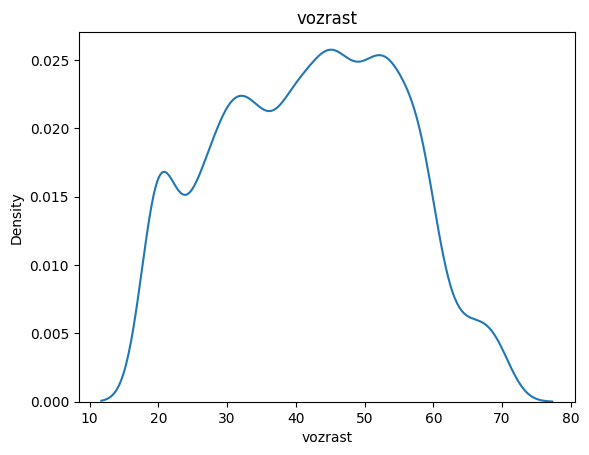

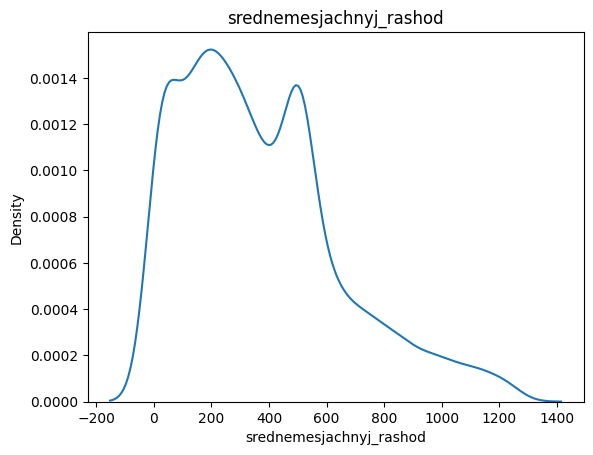

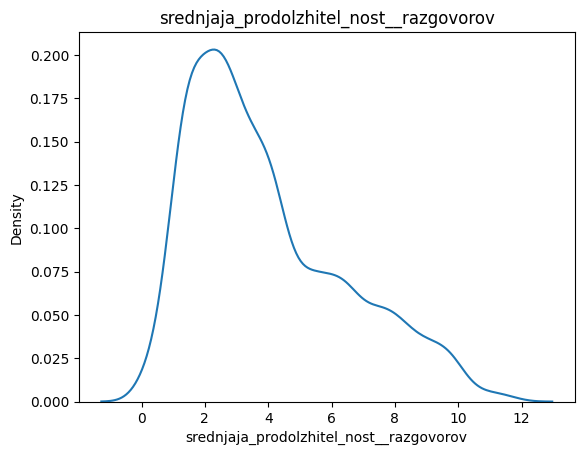

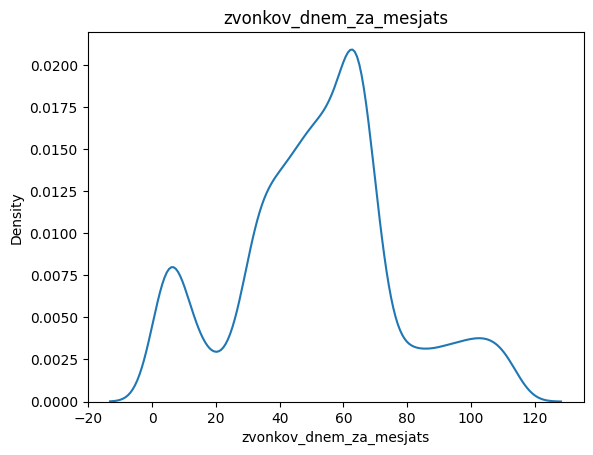

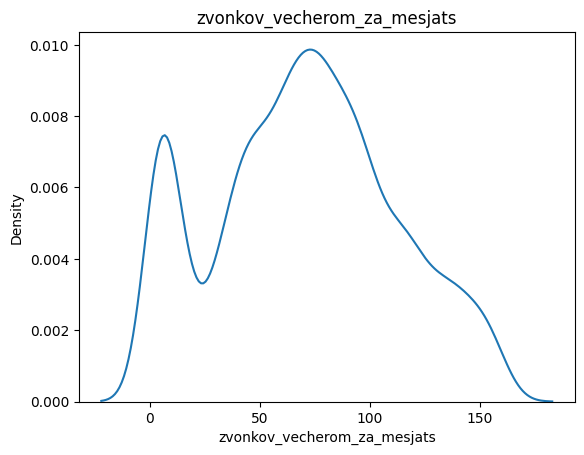

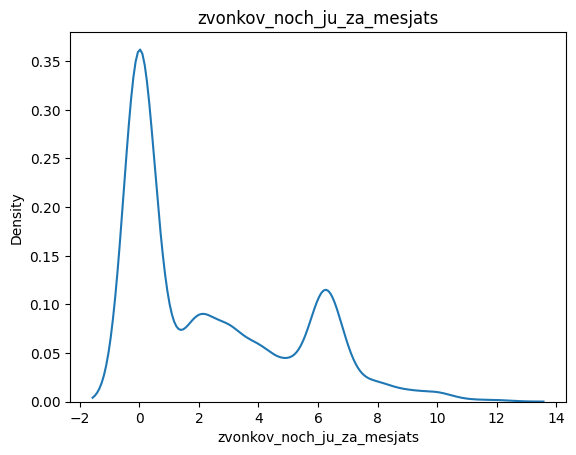

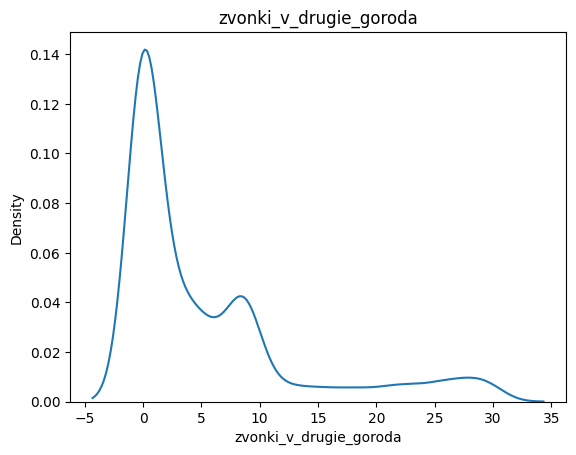

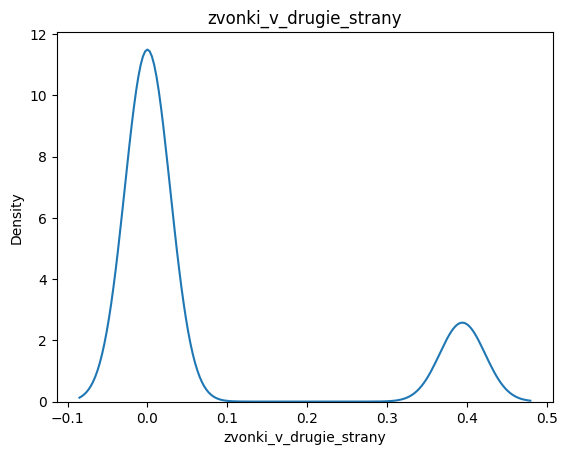

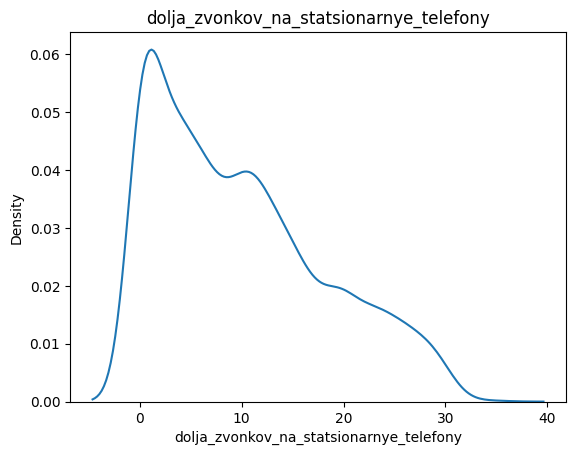

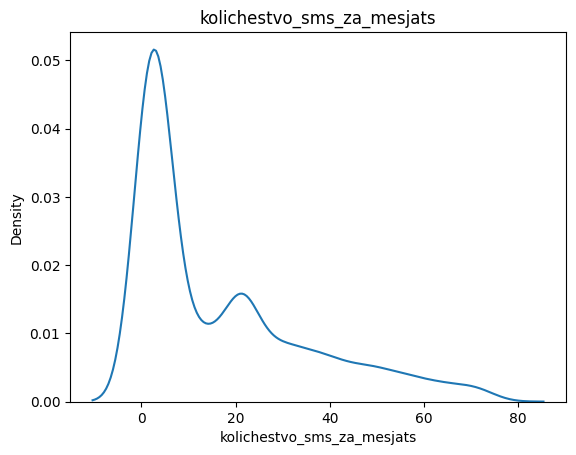

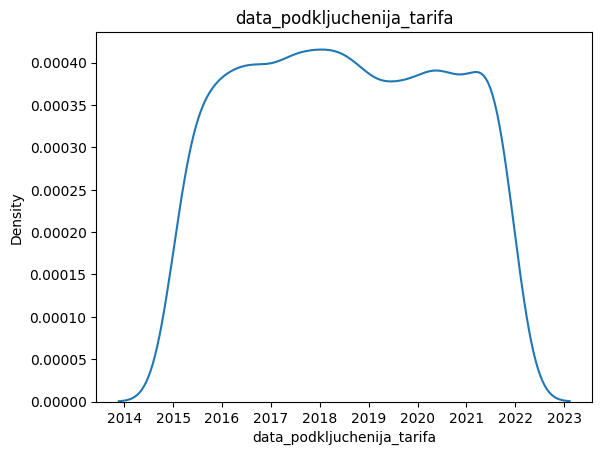

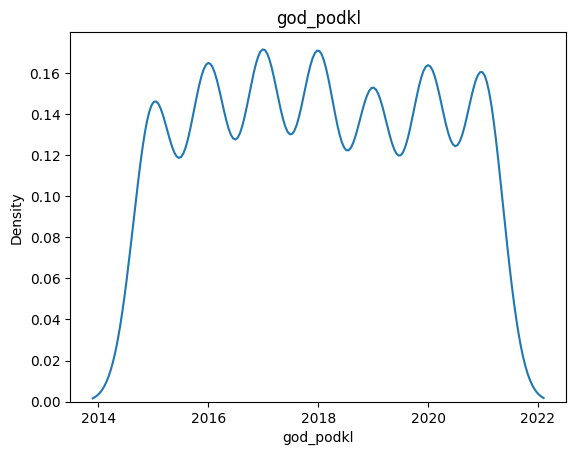

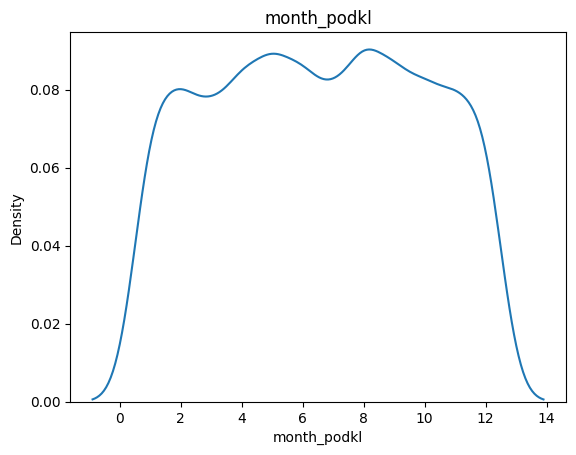

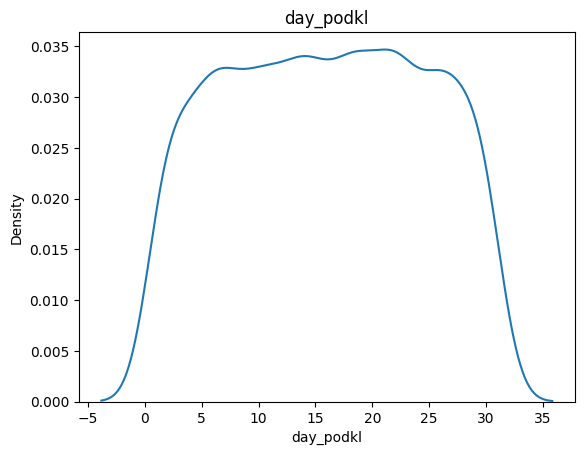

In [373]:
ml.plots('kde')

In [ ]:
ml.eda()

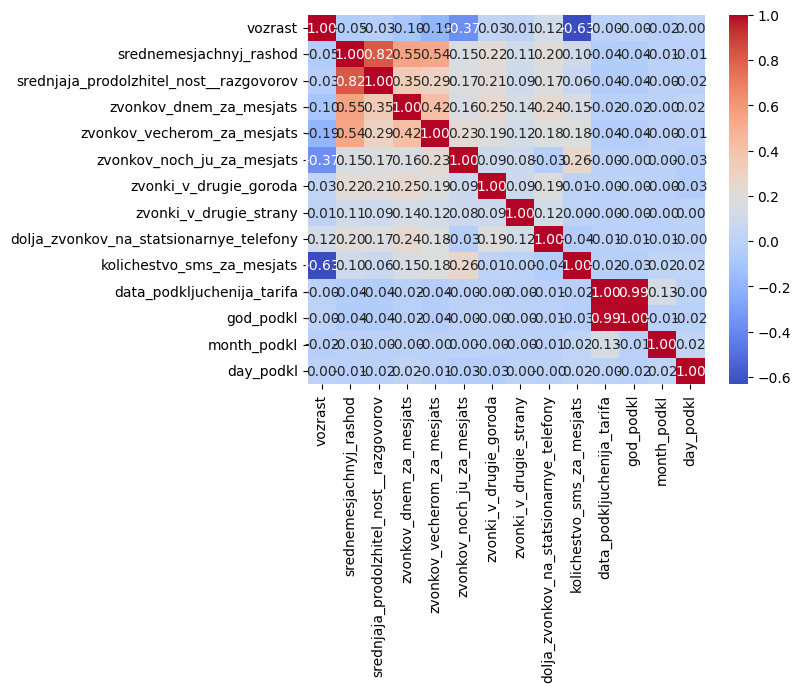

In [374]:
ml.correlation()

In [381]:
ml.eda()

Выберите опцию для анализа:
1. Самый прибыльный год
2. Самый прибыльный месяц
3. Самый прибыльный день
4. ТОП-10 дней по числу новых клиентов
5. Анализ по возрастным категориям
6. Кто больше всего тратит на оплату услуг связи

Больше всех в среднем в месяц тратят на оплату услуг связи: аспирант - 489.44 руб и бизнесмен - 384.83 руб


In [345]:
ml.regression(gs=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 452.2797313	test: 452.3360886	best: 452.3360886 (0)	total: 3.74ms	remaining: 3.74s
1:	learn: 440.8537468	test: 440.9179027	best: 440.9179027 (1)	total: 9.16ms	remaining: 4.57s
2:	learn: 429.2837036	test: 429.2612898	best: 429.2612898 (2)	total: 13ms	remaining: 4.31s
3:	learn: 417.9346198	test: 417.8175270	best: 417.8175270 (3)	total: 19.6ms	remaining: 4.88s
4:	learn: 407.5998802	test: 407.2592959	best: 407.2592959 (4)	total: 27.9ms	remaining: 5.56s
5:	learn: 397.2762651	test: 397.0937579	best: 397.0937579 (5)	total: 41.4ms	remaining: 6.86s
6:	learn: 387.3227766	test: 387.1111040	best: 387.1111040 (6)	total: 45.1ms	remaining: 6.39s
7:	learn: 377.4082803	test: 377.0847394	best: 377.0847394 (7)	total: 50.9ms	remaining: 6.31s
8:	learn: 368.0188431	test: 367.6547670	best: 367.6547670 (8)	total: 55.9ms	remaining: 6.16s
9:	learn: 358.4764726	test: 358.2011550	best: 358.2011550 (9)	total: 59.2ms	remaining: 5.86s
10:	learn: 349.7540908	test: 349.5026311	best: 349.5026311 (10)	total: 6

# Вывод

Предложенный алгоритм Catboost показывает себя на достаточно высоком уровне "прямо из коробки", что доказывается метриками.

r2_score (к-т детерминации) = 0,93 что говорит о крайне высоком качестве полученной модели, которая способна предсказывать траты каждого пользователя в зависимости от прееданных фичей. Данную модель можно с успехом использовать в реальных продуктовых задачах с целью выявления клиентов, которые готовы много тратить на услуги связи с целью удержания таких клиентов и повышения продуктовых/бизнесовых метрик, таких как LTV, AOV, ARPU и другие.

Дополнительно модель была подвергнута минимлаьной оптимизации с помощью алгоритма кросс-валидации, что также дает прирост качества целевых технических метрик.

Внутри реализованного класса есть множество методов, позволяющих провести тщательный и информативный анализ данных, на основе которого также можно сделать полезные для бизнеса выводы.